In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib


In [91]:
data = pd.read_csv("Bengaluru_House_Data.csv")


In [92]:
data.shape

(13320, 9)

In [93]:
data.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [94]:
df2 = data.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

Cleaning


In [95]:
df2.isnull().sum()  #find out how many null values exist

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [96]:
#since number of null <<< total number of entries we can drop them

data3 = df2.dropna()
data3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Feature engineering


In [97]:
data3['bhk'] = data3['size'].apply(lambda d: int(d.split(' ')[0]))
data3.bhk.unique()

C:\Users\Deepak\AppData\Local\Temp\ipykernel_20188\2594138415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['bhk'] = data3['size'].apply(lambda d: int(d.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [98]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [99]:
data3['total_sqft'].unique()
#data3[data3['total_sqft'].apply(is_float)].head()
data3[~data3['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


In [100]:
def set_avg(x):
    sqft = x.split('-')
    if len(sqft)== 2:
        avg = (float(sqft[0])+float(sqft[1]))/2
    try:
        return float(x)
    except:
        return None


In [101]:
data4 = data3.copy()

In [102]:
data4['total_sqft'] = data4['total_sqft'].apply(set_avg)

In [103]:
data4['total_sqft'].head()

0    1056.0
1    2600.0
2    1440.0
3    1521.0
4    1200.0
Name: total_sqft, dtype: float64

In [104]:
data5 = data4.copy()
data5['price_per_sqft'] = data5['price']*100000/data5['total_sqft']
data5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [105]:
data5.location = data5.location.apply(lambda x: x.strip())
location_stats = data5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                        535
Sarjapur  Road                    392
Electronic City                   304
Kanakpura Road                    266
Thanisandra                       236
                                 ... 
Vasantapura main road               1
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Abshot Layout                       1
Name: count, Length: 1293, dtype: int64

In [106]:
len(location_stats[location_stats>5])

385

In [107]:
len(location_stats)

1293

In [108]:
len(location_stats[location_stats<5])

852

In [109]:
location_stats_less_than_10 = location_stats[location_stats<10]
location_stats_less_than_10.head()

location
2nd Phase JP Nagar       9
KUDLU MAIN ROAD          9
4th Block Koramangala    9
Vignana Nagar            9
Ejipura                  9
Name: count, dtype: int64

In [110]:
len(data5.location.unique())

1293

In [111]:
data5.location = data5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(data5.location.unique())

255

# Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [112]:
data5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [113]:
data5[(data5.total_sqft/data5.bhk)<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [114]:
data6 = data5[~(data5.total_sqft/data5.bhk<300)]
data6.shape

(12502, 7)

In [115]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-(st))) & (subdf.price_per_sqft<=(m+(st)))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
data7 = remove_pps_outliers(data6)
data7.shape

(10120, 7)

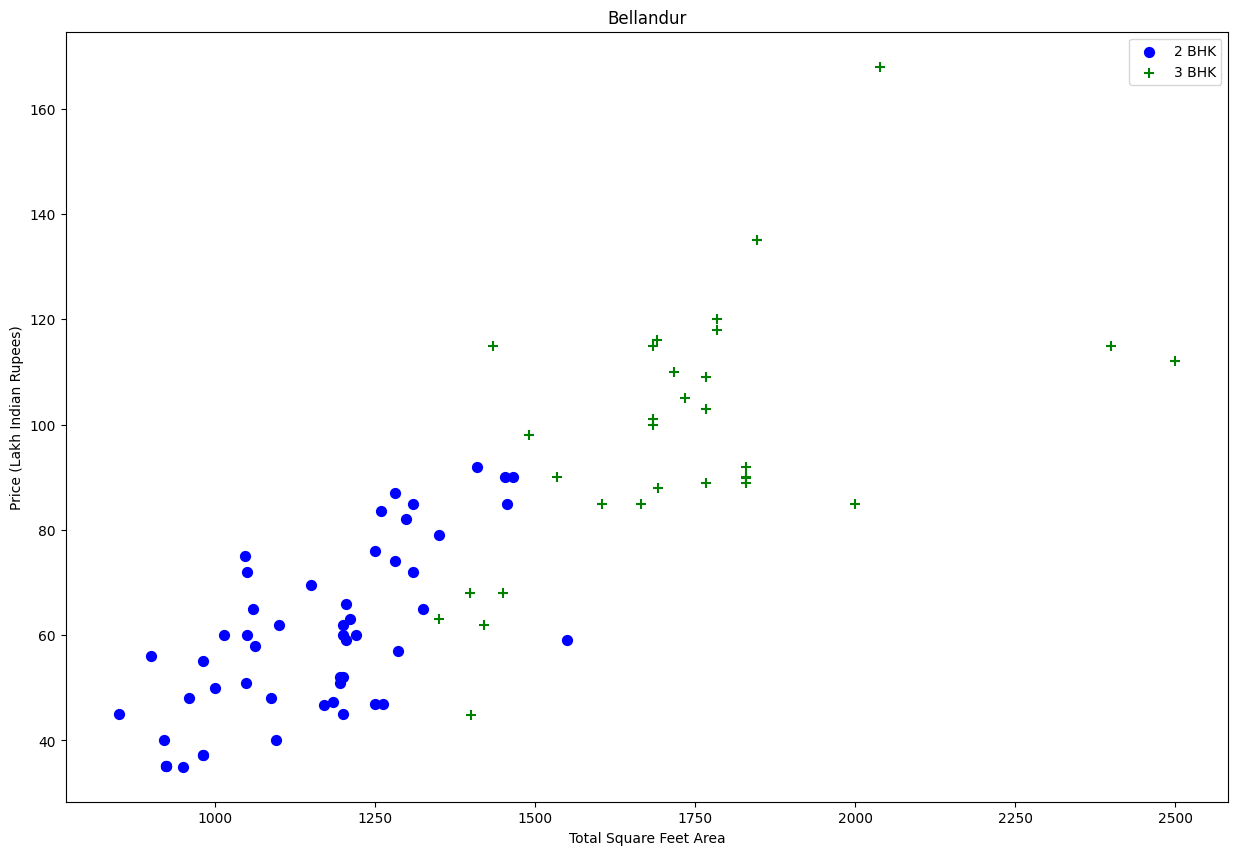

In [116]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(data7,"Bellandur")

In [117]:
data8 = data7[data7.bath<data7.bhk+2]
data8.shape

(10036, 7)

In [118]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
data9 = remove_bhk_outliers(data8)

data9.shape

(7192, 7)

In [119]:
newData = data9.drop(['size','price_per_sqft'],axis='columns')
newData.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


# ML model prep

One hot encoding is a technique that we use to represent categorical variables as numerical values in a machine learning model.

In [120]:
dummies = pd.get_dummies(newData,columns=['location'],dtype=int)
dummies.count()

total_sqft                      7192
bath                            7192
price                           7192
bhk                             7192
location_1st Block Jayanagar    7192
                                ... 
location_Yelahanka              7192
location_Yelahanka New Town     7192
location_Yelenahalli            7192
location_Yeshwanthpur           7192
location_other                  7192
Length: 259, dtype: int64

In [121]:
data10 = dummies
data10.head()

,total_sqft,bath,price,bhk,location_1st Block Jayanagar,location_1st Block Koramangala,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,...,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur,location_other
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
for column in data10.columns:
    if column.startswith('location_'):
        new_column_name = column.replace('location_', '')
        data10.rename(columns={column: new_column_name}, inplace=True)
data10.describe()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
count,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,...,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000
mean,1477.724106,2.419633,97.471432,2.492075,0.000973,0.000695,0.002225,0.001112,0.000556,0.000834,...,0.000556,0.000556,0.004310,0.029477,0.001529,0.011541,0.003337,0.001112,0.004867,0.152253
std,884.807093,0.936857,92.623017,0.908523,0.031185,0.026360,0.047117,0.033336,0.023578,0.028874,...,0.023578,0.023578,0.065516,0.169152,0.039081,0.106813,0.057675,0.033336,0.069595,0.359290
min,300.000000,1.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1095.000000,2.000000,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,2.000000,73.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1655.250000,3.000000,110.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30400.000000,16.000000,2200.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
X = data10.drop(['price'],axis='columns')
X.head(10)



,total_sqft,bath,bhk,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2750.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2450.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1415.0,2.0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,860.0,2.0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3000.0,3.0,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
y = data10.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [126]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8531589844455818

In [127]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.90225806, 0.85865614, 0.89445498, 0.90168759, 0.85204047])

In [128]:
X.columns
X.shape

(7192, 258)

In [129]:
loc_index = np.where(X.columns=='1st Block Jayanagar')[0][0]
loc_index


3

In [130]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
        
    return lr_clf.predict([x])[0]

In [132]:
predict_price('1st Block Jayanagar',2850,4,4)

d:\Deepak\Deepak -CS\DS\New folder\DP\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


353.36575880373385

In [133]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))